**bold text**# AI534 Implementation 1###
**Deadline**: Sunday, Oct. 15, by 11:59pm

**Submission**: Submit 1) your completed notebook in ipynb format, and 2) a PDF export of the completed notebook with outputs.

**Late Submission**: Please see the syllabus for the late submission policy.

In this assignment, we will implement and experiment linear regression to predict the price of a house based on features describing the house, using the housing data that you have explored in the warm up assignment.

We will implement two versions, one using the closed-form solution, and one using gradient descent.

You may modify the starter code as you see fit, including changing the signatures of functions and adding/removing helper functions. However, please make sure that your TA can understand what you are doing and why.

First lets import the necessary packages.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# add more imports if necessary

# Part 0: (5 pts) data and preprocessing

---

On canvas, we have provided two different data files for this assignment: ia1_train.csv (for training) and ia1_val.csv(for validation). Download them and upload them to your google drive. Then mount the google drive from your google colab notebook:


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

train_path = '/content/gdrive/MyDrive/AI534/ia1_train.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
val_path   = '/content/gdrive/MyDrive/AI534/ia1_val.csv'   # DO NOT MODIFY THIS. Please make sure your data has this exact path
kaggle_path='/content/gdrive/MyDrive/AI534/PA1_test1.csv'

Mounted at /content/gdrive


Now load the training and validation data.

In [ ]:
# your code goes here
train_data = pd.read_csv(train_path)
val_data   = pd.read_csv(val_path)
kaggle_data   = pd.read_csv(kaggle_path)

train_data.dtypes

id                 int64
date              object
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
price            float64
dtype: object

Perform the following preprocessing steps.
1. remove the *ID* column from both training and validation data
2. change *date* into 3 numerical features *day*, *month* and *year*, like in the warm up exercise
3. The feature *yr_renovated* is set to 0 if the house has not been renovated. This creates an inconsistent meaning to the numerical values. Replace it with a new feature called *age_since_renovated*:

>if *yr_renovate* != 0
>> *age_since_renovated* = *year* - *yr\_reno`vated*  

>otherwise
>> *age\_since\_renovated = year - yr\_built*

4. Normalize all the feautres using z-score normalization based on the training data. Do not normalize *price* as it is the target.
To normalize a feature *x* using z-score normalization, the formula is

>$z=\frac{x-\mu}{\sigma}$

where $\mu$ and $\sigma$ are the mean and standard deviation of $x$ respectively. The normalized feature will have zero mean and unit standard deviation. Note that you should estimate $\mu$ and $\sigma$ for each feature only using the training data and use the same $\mu$ and $\sigma$ to normalize the features for both training and validation data.




In [ ]:
# Your code goes here
processed_train_data = train_data.drop(columns=['id'])
processed_val_data   = val_data.drop(columns=['id'])
processed_kaggle_data   = kaggle_data.drop(columns=['id'])

# from ia0
#2. handle the date feature and convert it to datetime
processed_train_data['date']=pd.to_datetime(processed_train_data['date'], format='%m/%d/%Y')

# extract month, day, and year into separate columns
processed_train_data['SaleMonth'] = processed_train_data['date'].dt.month
processed_train_data['SaleDay']   = processed_train_data['date'].dt.day
processed_train_data['SaleYear']  = processed_train_data['date'].dt.year

#drop the original date column
processed_train_data=processed_train_data.drop(columns=['date'])

#fix yr_renovated
processed_train_data['age_since_renovated'] = processed_train_data.apply(lambda row:
    row['SaleYear'] - row['yr_renovated'] if row['yr_renovated'] != 0 else row['SaleYear'] - row['yr_built'], axis=1)
processed_train_data = processed_train_data.drop(columns=['yr_renovated'])
columns_to_normalize = [col for col in processed_train_data.columns if col != 'price']
unnormalized_train_data=processed_train_data.copy()

# Calculate the mean and standard deviation for training data
mean_values          = processed_train_data[columns_to_normalize].mean()
std_deviation_values = processed_train_data[columns_to_normalize].std()

# Apply z-score normalization
processed_train_data[columns_to_normalize] = (processed_train_data[columns_to_normalize] - mean_values) / std_deviation_values
processed_train_data.dtypes

#2. handle the date feature and convert it to datetime
processed_val_data['date'] = pd.to_datetime(processed_val_data['date'], format='%m/%d/%Y')

#extract month, day, and year into separate columns
processed_val_data['SaleMonth'] = processed_val_data['date'].dt.month
processed_val_data['SaleDay']   = processed_val_data['date'].dt.day
processed_val_data['SaleYear']  = processed_val_data['date'].dt.year

#drop the original date column
processed_val_data=processed_val_data.drop(columns=['date'])
processed_val_data['age_since_renovated'] = processed_val_data.apply(lambda row:
    row['SaleYear'] - row['yr_renovated'] if row['yr_renovated'] != 0 else row['SaleYear'] - row['yr_built'], axis=1)
processed_val_data = processed_val_data.drop(columns=['yr_renovated'])
#normalize validation data using training distribution
unnormalized_val_data=processed_val_data.copy()

processed_val_data[columns_to_normalize] = (processed_val_data[columns_to_normalize] - mean_values) / std_deviation_values
processed_val_data.dtypes

#2. handle the date feature and convert it to datetime
processed_kaggle_data['date'] = pd.to_datetime(processed_kaggle_data['date'], format='%m/%d/%Y')

#extract month, day, and year into separate columns
processed_kaggle_data['SaleMonth'] = processed_kaggle_data['date'].dt.month
processed_kaggle_data['SaleDay']   = processed_kaggle_data['date'].dt.day
processed_kaggle_data['SaleYear']  = processed_kaggle_data['date'].dt.year

#drop the original date column
processed_kaggle_data=processed_kaggle_data.drop(columns=['date'])
processed_kaggle_data['age_since_renovated'] = processed_kaggle_data.apply(lambda row:
    row['SaleYear'] - row['yr_renovated'] if row['yr_renovated'] != 0 else row['SaleYear'] - row['yr_built'], axis=1)
processed_kaggle_data = processed_kaggle_data.drop(columns=['yr_renovated'])

processed_kaggle_data[columns_to_normalize] = (processed_kaggle_data[columns_to_normalize] - mean_values) / std_deviation_values
processed_kaggle_data.dtypes



bedrooms               float64
bathrooms              float64
sqft_living            float64
sqft_lot               float64
floors                 float64
waterfront             float64
view                   float64
condition              float64
grade                  float64
sqft_above             float64
sqft_basement          float64
yr_built               float64
zipcode                float64
lat                    float64
long                   float64
sqft_living15          float64
sqft_lot15             float64
SaleMonth              float64
SaleDay                float64
SaleYear               float64
age_since_renovated    float64
dtype: object

Let's do a quick testing of your normalization, please
1. Estimate and print the new mean and standard deviation of the normalized features for the training data --- this should be 0 and 1 respectively.  
2. Estimate and print the new mean and standard deviation of the normalized features for the validation data --- these values will not be 0 and 1, but somewhat close

In [ ]:
# Your code goes here
# Calculate the new mean and standard deviation for the normalized features in the training data
new_mean_train = processed_train_data[columns_to_normalize].mean()
new_std_deviation_train = processed_train_data[columns_to_normalize].std()

# Print the results
print("Training Data:")
print("New Mean:")
print(new_mean_train)
print("New Standard Deviation:")
print(new_std_deviation_train)

new_mean_validation = processed_val_data[columns_to_normalize].mean()
new_std_deviation_validation = processed_val_data[columns_to_normalize].std()
print("Validation Data:")
print("New Mean:")
print(new_mean_validation)
print("New Standard Deviation:")
print(new_std_deviation_validation)


Training Data:
New Mean:
bedrooms               1.953993e-16
bathrooms             -1.776357e-16
sqft_living            8.704149e-17
sqft_lot              -3.552714e-18
floors                 2.176037e-17
waterfront             1.465494e-17
view                   1.953993e-17
condition              1.163514e-16
grade                  8.348877e-17
sqft_above            -1.030287e-16
sqft_basement          7.105427e-18
yr_built               3.389289e-15
zipcode                3.703171e-14
lat                   -4.131273e-14
long                   9.379075e-14
sqft_living15          6.217249e-17
sqft_lot15            -3.552714e-18
SaleMonth             -3.419487e-17
SaleDay               -2.919887e-17
SaleYear               1.992757e-13
age_since_renovated   -9.769963e-17
dtype: float64
New Standard Deviation:
bedrooms               1.0
bathrooms              1.0
sqft_living            1.0
sqft_lot               1.0
floors                 1.0
waterfront             1.0
view              


## ***Question***
Why is it import to use the same $\mu$ and $\sigma$ to perform normalization on the training and validation data? What would happen if we use $\mu$ and $\sigma$ estimated using the validation to perform normalization on the validation data?  


Because the model will be trained on the distribution of data found within the training set. If the validation set is normalized with different parameters the dataset will be shifted and offset by some amount that will throw off the predictions.

# Part 1 (15 pts) Generate closed-form solution for reference.
Our data now contains 21 numeric features, before we learn a linear regression model using gradient descent, we will first build the closed-form solution as a reference point. So for this part, you need to
1. Implement the close-form solution for linear regression and apply it to the training data to learn the weight vector for your linear regression model.
2. Apply your learned linear regression model to the training data to make predictions for all training examples and report the Mean Squared Error.
3. Apply your learned linear regression model to the validation data to make predictions for all the validation examples and report the mean squared error for the validation data.

Your code should print the weight vector, which has 22 dimensions, one for each feature plus one additional $w_0$.  Your code should also report the MSE for the training and validation data respectively.*italicized text*

In [ ]:
# Your code goes here
# Add column for the bias w0
processed_train_data['bias'] = 1
processed_val_data['bias']   = 1

processed_kaggle_data['bias'] = 1


# feature matrices
X_train      = processed_train_data[columns_to_normalize + ['bias']].values
X_validation = processed_val_data[columns_to_normalize   + ['bias']].values

#target vectors
Y_train      = processed_train_data['price'].values
Y_validation = processed_val_data['price'].values

#Linear-Regression-2 (updated).pdf slide 19
#w= (XtX)^-1 XtY
# closed-form solution weight vector
XtX = np.dot(X_train.T, X_train)
XtY = np.dot(X_train.T, Y_train)
w = np.dot(np.linalg.inv(XtX), XtY)

print("Weight Vector (w):")
print_columns=columns_to_normalize+['bias']
for i in range(len(print_columns)):
  print(print_columns[i]+":"+str(w[i]))

# Make predictions
Y_train_pred = np.dot(X_train, w)
Y_validation_pred = np.dot(X_validation, w)

# Calculate Mean Squared Error
mse_train = np.mean((Y_train - Y_train_pred) ** 2)
print("Training MSE:", mse_train)
mse_validation = np.mean((Y_validation - Y_validation_pred)**2)
print("Validation MSE:", mse_validation)


Weight Vector (w):
bedrooms:-2.162987322900752
bathrooms:1.0391276733157089
sqft_living:1.0734638789206405
sqft_lot:0.09137159962809141
floors:-0.27471762952030276
waterfront:0.3881638792374852
view:0.2888751318539667
condition:0.16587905820056292
grade:1.1347417702620775
sqft_above:2.562303946435951
sqft_basement:0.36222635847349505
yr_built:-0.8833617141584866
zipcode:-0.2634187373257933
lat:0.8366124800413349
long:-0.3036964061101171
sqft_living15:0.14358099361272803
sqft_lot15:-0.09927428347952406
SaleMonth:0.05485034976659838
SaleDay:-0.05063651693935755
SaleYear:0.17375019364819705
age_since_renovated:-0.10255779001893162
bias:5.361672840000037
Training MSE: 8.491691887695369
Validation MSE: 8.506913959966845


In [ ]:
X_train.shape, X_validation.shape

((8000, 22), (2000, 22))

## Question
The learned feature weights are often used  to understand the importance of the features. The sign of the weights indicates if a feature positively or negatively impact the price, and the magnitude suggests the strength of the impact. Does the sign of all the features match your expection based on your common-sense understanding of what makes a house expensive? Please hightlight any surprises from the results.

---


Many of the signs defy my expectations, especially vexing is having more bedrooms beins strongly correlated with a lower price. The latitude and longitude having such a strong impact on the price surprised me. Floors being negative is simmilarly odd. The rest are somewhat expected


# Part 2 (40 pts) Implement and experiment with batch gradient descent

Your implementation should take following inputs:

1. the training data (with $d$ features and 1 target variable $y$),

2. the learning rate $\gamma$,

3. the number of iterations $T$

4. Optional convergence threshold (optional) $\epsilon_l$ for the loss or $\epsilon_g$ for the norm of the gradient

It should output:
1. the learned $d+1$ - dimensional weight vector
2. the sequence of $T$ MSE losses, one for each training epoch. You will be asked to plot the losses as a function of training epoch later.


In [ ]:
from tqdm import tqdm

def batch_gradient_descent(X, Y, learning_rate, num_iterations, epsilon=None, max_grad=False):
    #w = np.random.randn(X.shape[1])
    w = np.zeros(X.shape[1])
    N=X.shape[0]
    mse_tseq = []  # To store mse for graph plotting

    for epoch in tqdm(range(num_iterations)):
      # Calculate predictions
      y_pred = np.dot(X, w)

      # Calculate gradient
      gradient = (-2/N) * np.dot(X.T, Y - y_pred)
      # Update the weight vector
      w -= learning_rate * gradient

      # Calculate the mean squared error
      mse = np.mean((Y - y_pred) ** 2)
      mse_tseq.append(mse)
      norm=np.linalg.norm(gradient)
      if epsilon and norm < epsilon:
        print("Converged at epoch", epoch)
        break
      if max_grad and norm > max_grad:
        print("Diverged at epoch", epoch)
        break

    return w, mse_tseq,norm

100%|██████████| 3000/3000 [00:00<00:00, 3900.49it/s]


final mse: 13.204888078573441
Trained Weight Vectors
[ 0.10943211  0.33257777  0.54031293  0.03220432  0.14116905  0.2233698
  0.37532813  0.13576934  0.56871747  0.46880523  0.23651071 -0.18148952
  0.0286299   0.44024569 -0.12370683  0.43035754  0.01294165 -0.01066901
 -0.04201445  0.02176711  0.11656759  2.41930097]


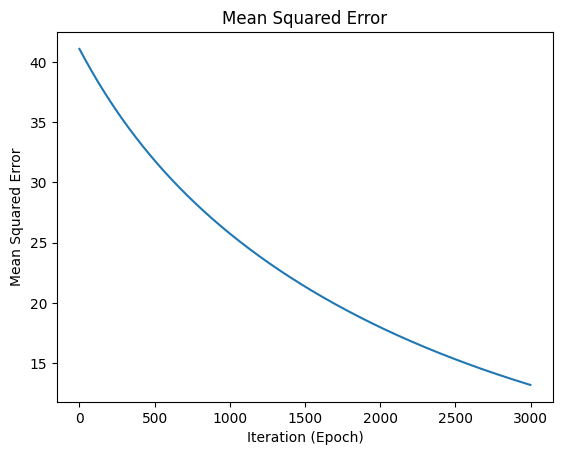

In [ ]:
# Your code goes here
from tqdm import tqdm

num_iterations = 3000                                  # count iteration
learning_rate  = 1e-4                        # initialize learning rate
mse_tseq  = []                                         # store mse for graph plotting
epsilon   = 1e-3                                     # Stopping criteria
max_grad  = 1e20                                         # Stopping criteria for divergence

w, mse_tseq,_=batch_gradient_descent(X_train,Y_train,learning_rate,num_iterations,epsilon,max_grad)
print("final mse:",mse_tseq[-1])
# output trained weight
print("Trained Weight Vectors")
print(np.squeeze(w))

# output sequence of T MSE losses
plt.plot(mse_tseq)
plt.title("Mean Squared Error")
plt.xlabel("Iteration (Epoch)")
plt.ylabel("Mean Squared Error")
plt.show()

You will now experiment with the batch gradient descent algorithm with different learning rate on the provided data.

Please train your model for up to 3000 iterations using different learning rate: $\gamma=10^{-i}$, $i=0,1,...,4$. For each learning rate, you can opt to stop early if it has converged (using the convergence threshold) or diverged (the loss start to grow larger).

For each converging (not necessarily converged yet) learning rate, please compute and report the MSE of the final learned weights on the validation data.

Also please provide a plot that shows the training loss curves (MSE as a function of the # of epochs) for all the converging learning rates. Please use different colors mark different learning rates and provide proper legends for your figure.


In [ ]:
# Your code goes here
from tqdm import tqdm
# Training model


max_iter  = 3000                                         # maxium iteration
epsilon   = 1e-2                                         # Stopping criteria for convergence
max_grad  = 1e20                                         # Stopping criteria for divergence
N         = X_train.shape[0]                             # Number of training data
mse_curve = {}                                           # Store MSE loss for different learning rate
weights   = {}                                           # Store weight learned for different learning rate

for lr in [1e0, 1e-1, 1e-2, 1e-3, 1e-4]:                 # Loop for different learning rate
  w, mse_tseq, norm=batch_gradient_descent(X_train,Y_train,lr,max_iter,epsilon,max_grad)
  if norm>max_grad:
    continue
  mse_curve[str(lr)] = mse_tseq                          # store sequence of T MSE in dictionary
  weights[str(lr)]   = w                               # store trained weight in dictionary


  1%|          | 19/3000 [00:00<00:02, 1136.59it/s]


Diverged at epoch 19


  5%|▍         | 143/3000 [00:00<00:00, 3768.87it/s]


Converged at epoch 143


 48%|████▊     | 1439/3000 [00:00<00:00, 4468.49it/s]


Converged at epoch 1439


100%|██████████| 3000/3000 [00:00<00:00, 4963.64it/s]


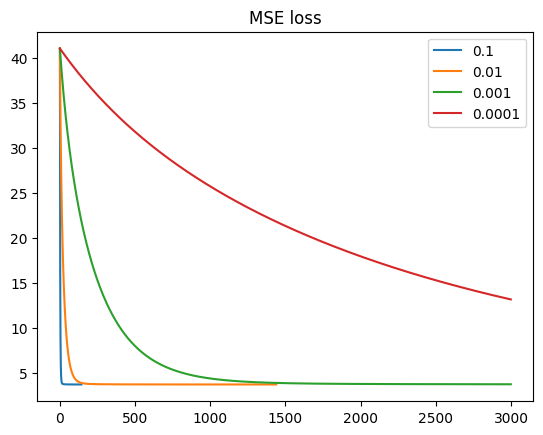

In [ ]:
# Plot training loss

for i in mse_curve:
  y = mse_curve[i]
  x = range(len(y))
  plt.plot(x, y, label=f'{i}')
  plt.title(f'MSE loss')
plt.legend(loc="upper right")
plt.show()

In [ ]:
# Calcualte final MSE Loss in validation dataset

mse_all   = {}

for lr in  weights:
  mse = 0
  mse_train = 0
  w_0 = weights[lr]

  for X, Y in zip(X_validation, Y_validation):
      x    = X[..., np.newaxis]                    # Adding new axis to change shape of numpy from (22,) to (22,1) for matrix multiplication
      pred = np.squeeze(np.matmul(w_0.T, x))
      mse  += (Y - pred)**2                        # calculate square error (mse)

  for X, Y in zip(X_train, Y_train):
      x    = X[..., np.newaxis]                    # Adding new axis to change shape of numpy from (22,) to (22,1) for matrix multiplication
      pred = np.squeeze(np.matmul(w_0.T, x))
      mse_train  += (Y - pred)**2                  # calculate square error (mse)

  mse /= X_validation.shape[0]
  mse_train /= X_train.shape[0]

  mse_all[lr] = [mse_train, mse]

# Output MSE in validation dataset trained with different learningrate
for lr in mse_all:
  print(f'Learning Rate {lr} | train_MSE: {mse_all[lr][0]} | val_MSE: {mse_all[lr][1]}')

Learning Rate 0.1 | train_MSE: 3.7581717887035024 | val_MSE: 4.503628267890317
Learning Rate 0.01 | train_MSE: 3.7581825973555247 | val_MSE: 4.503632218460766
Learning Rate 0.001 | train_MSE: 3.7812460385444298 | val_MSE: 4.525749834788354
Learning Rate 0.0001 | train_MSE: 13.201072183427186 | val_MSE: 14.4654825101023


## Question

Which learning rate leads to the best trainng and validation MSE respectively? Do you observe better training MSE tend to correpsond to better validation MSE? How is this different from the trend shown in slide 43 (titled danger of using training loss to select M) discussed in class regarding overfitting? Is there any issue with using training loss to pick learning rate in this case?

According to the observation, a learning rate of 0.01 $(1e^{-2})$ has the least training MSE, while a learning rate of 0.1 $(1e^{-2})$ has a lower validation mean squared error (MSE), which is 3.758 and 4.504, respectively. However, the MSE of 0.1 and 0.01 for both training and validation is almost the same.<br>

Yes, from the above result, it is seen that better training MSE corresponds to better validation MSE.<br>

There is a difference between the trend shown in slide 43 and the result observed from training MSE and validation MSE because, due to the learning rate, convergence of the model has affected a lot. From the above plotted graph, we can clearly see that the learning rate of 0.1 has high convergence, so it has achieved less MSE only in a few iterations (epochs), while the learning rate of 0.0001 hasn't converged yet. It seems that for a lower learning rate, we should increase the number of iterations (epochs) to get lower MSE.<br>

In this case, there is no issue with using training loss to pick the learning rate because, by comparing the loss between the different learning rates, we can observe how fast the model is converging or diverging. In this case, comparing the training loss, we found that 0.1 or 0.01 is good for training the model.


# Part 3. More exploration.

## **3(a). (20 pts) Normalization of features: what is the impact?**
In part 1, you were asked to perform z-score normalization of all the features except for binary ones. In this part, we will ask you to first conceptually think about what is the impact this operation on the solution and then use some experiments to varify your conceptual understanding.

### **Questions.**

The normalization process applies a linear transformation to each feature, where the transformed feature $x'$ is simply a linear function of original feature $x$: $x'=\frac{x-\mu}{\sigma}$.

Let's disect the influence of this transformation on our learned linear regression model.
1. How do you think this transformation will influnce the training and validation MSE we get for the closed-form solution? Why?
2. How do you think this will change the magnitude of the weights of the learned model? Why?
3. How do you think this will change the convergence behavior of the batch gradient descent algorithm? Why?



1.   I think there won't be much difference in the result after normalizing the features. Because in a closed-form solution, we don't need to calculate the gradient, and there is no convergence issue. The time to calculate normalized data and non-normalized data is the same.

2.   The magnitude of the weights for all the features will have a similar range. Because all the features are normalized and mapped into the same unit, Important features will have higher weights, but the variance will be very low.

3.   I think the model will converge faster after normalization because the gradient components of the cost function have similar scales, which prevents overshooting for a single learning rate. If the features have different gradients, then the selected learning rate might be very large for some gradients while it might be very low for other features, which might cause overshooting and decrease the speed of convergence.

Now please perform the following experiments to verify your answer to the above questions.
1. Apply closed-form solution to data that did not go through the feature normalization step, and report the learned weights and the resulting training and testing MSEs.
2. Apply gradient descent algorithm to data that did not go through the feature normalization step using different learning rate. Note that the learning rate used in previous section will no longer work here. You will need to search for an appropriate learning rate to get convergence. (Hint: this needs to be much much smaller than what was used in part 2). Plot your MSE loss curve as a function of the epochs once you identify a convergent learning rate.

In [ ]:
# Your code goes here


unnormalized_train_data['bias'] = 1
unnormalized_val_data['bias']   = 1

# feature matrices
X_train      = unnormalized_train_data[columns_to_normalize + ['bias']].values
X_validation = unnormalized_val_data[columns_to_normalize   + ['bias']].values

#target vectors
Y_train      = unnormalized_train_data['price'].values
Y_validation = unnormalized_val_data['price'].values

In [ ]:
# closed-form solution weight vector
XtX = np.dot(X_train.T, X_train)
XtY = np.dot(X_train.T, Y_train)
w = np.dot(np.linalg.inv(XtX), XtY)

print("Weight Vector (w):")
print("**********************************************************")
for i in range(len(print_columns)):
  print(print_columns[i]+":"+str(w[i]))

# Make predictions
Y_train_pred = np.dot(X_train, w)
Y_validation_pred = np.dot(X_validation, w)

# Calculate Mean Squared Error
mse_train = np.mean((Y_train - Y_train_pred) ** 2)
print("**********************************************************")

print("Training MSE:", mse_train)
mse_validation = np.mean((Y_validation - Y_validation_pred)**2)
print("Validation MSE:", mse_validation)

Weight Vector (w):
**********************************************************
bedrooms:-1.1900657758008037
bathrooms:2.221586554874193
sqft_living:0.309857589789317
sqft_lot:6.359981478062937e-07
floors:-6.198969807997855
waterfront:160.71855056575987
view:-9.592111972713155
condition:-3.54895475131525
grade:3.7220816295821635
sqft_above:-0.30067364004207775
sqft_basement:-0.3038981799327303
yr_built:-0.02996562110367762
zipcode:-0.004928507591301923
lat:6.034992968194274
long:-2.141960201019174
sqft_living15:0.00020974348418700828
sqft_lot15:-3.3776994350816214e-06
SaleMonth:0.01757182190340245
SaleDay:-0.005882854013236738
SaleYear:0.373189368416206
age_since_renovated:-0.003549653841332656
bias:-764.9582085609436
**********************************************************
Training MSE: 378.2050760483736
Validation MSE: 412.26148948481574


In [ ]:
X_train.shape, X_validation.shape

((8000, 22), (2000, 22))

100%|██████████| 30000/30000 [00:08<00:00, 3675.41it/s]


Trained Weight Vectors
[ 5.84182928e-08  7.95978326e-08  1.25115966e-04  4.21851727e-06
  2.97792181e-08  3.32062910e-09  5.91620099e-08  9.17539435e-09
  1.59168068e-07  9.99428242e-05  2.51731422e-05  1.13888186e-06
  4.73843365e-05  3.23523693e-08 -5.97589606e-08  7.93189887e-05
  3.43760359e-06  3.70922547e-09 -5.36300724e-08  9.78278722e-07
 -4.15655940e-07  4.85954886e-10]
final mse: 11.160643139845876


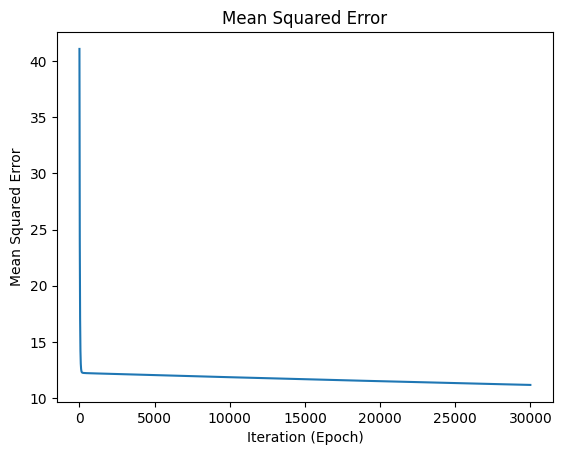

In [ ]:
# Batch Gradient descent training with

# Your code goes here
epsilon   = 1e-1                                       # Stopping criteria
lr        = 1e-12                                      # initialize learning rate
max_grad  = 1e20
itterations=30000

w, mse_tseq, _ = batch_gradient_descent(X_train,Y_train,lr,itterations,epsilon,max_grad)

# output trained weight
print("Trained Weight Vectors")
print(np.squeeze(w))

print("final mse:",mse_tseq[-1])
# output sequence of T MSE losses
plt.plot(mse_tseq)
plt.title("Mean Squared Error")
plt.xlabel("Iteration (Epoch)")
plt.ylabel("Mean Squared Error")
plt.show()

**Questions**

Please revisit the questions above. Does your experiment confirm your expectation?  Can you provide explanations to the observed differences (or lack of differences) between the normalized data and unnormalized data? Based on these observations and your understanding of them, please comment on the benefits of normalizing the input features in learning for linear regressions.


Yes, the above experiment confirm my expectation. <br>

When the data was normalized, the model was able to converge even with a very high learning rate of .1, but for non-normalized data using it the model diverges very quickly. So we used learning rate of $1e^{-12}$.Similarly, data normalization has highly increased the convergence rate of the model. When the model is not normalized MSE error of the model is around $11$ at 10000 iteration. While we achieved MSE rror of 3.758 at far fewer iteration on the normalized data.

**Benefits of normalization**

1.   Normalization allows to use higher learning rate without which avoids problems like vanishing gradient and exploding gradient
2.   Better convergence improves the performance of the model.
3.   Since all the features are scaled to the same range, all of them have equal importance.



## **3(b). (20 pts) explore the impact of redundant features**

In the warm up exercise, you all have seen some features are highly correlated with one another. For example, there are multiple squared footage related features that are strongly correlated (e.g., *sqft_above* and *sqrt_living* has a correlation coefficient of 0.878).  This is referred to as multicollinearity phenomeon, where two or more features are correlated.

There are numerous consequences from multicollinearity. It makes it more challenging to estimate the weights of the features accurately. The weights may become unstable, and their interpretation becomes less clear.

In this part you will start with the pre-processed training set, and perform the following experiments **using the closed-form solution**.
Specifically, your code should:
1. randomly subsample 75% percent of the training data (with normalized features) for five times
2. creating five slighly different training sets that are 75% of the original training set size.
3. for each such training set, perform learning using the closed-form solution and report the learned weight vector in a table, where you can show each weight vector solution as a row (or column in the table), and include a header for your table to indicate the corresponding feature name for each weight coefficient.

In [ ]:
# Normalize the training dataset
columns_to_normalize = [col for col in processed_train_data.columns if col != 'price' and col != 'bias']

# Calculate the mean and standard deviation for training data
mean_values          = processed_train_data[columns_to_normalize].mean()
std_deviation_values = processed_train_data[columns_to_normalize].std()

# Apply z-score normalization
processed_train_data[columns_to_normalize] = (processed_train_data[columns_to_normalize] - mean_values) / std_deviation_values

In [ ]:
# Your code goes here
def closed_form_solution(X_train, Y_train):
  XtX = np.dot(X_train.T, X_train)
  XtY = np.dot(X_train.T, Y_train)
  w   = np.dot(np.linalg.inv(XtX), XtY)

  return w


# feature matrices
X_train      = processed_train_data[columns_to_normalize + ['bias']].values
X_validation = processed_val_data[columns_to_normalize   + ['bias']].values


# target vectors
Y_train      = processed_train_data['price'].values
Y_validation = processed_val_data['price'].values

num_of_subsample = int(0.75 * X_train.shape[0])

weight_distribution = pd.DataFrame(columns = processed_train_data[columns_to_normalize + ['bias']].columns.tolist())

# randomly sampling training dataset
for i in range(5):
  random_choice  = np.random.randint(X_train.shape[0], size=num_of_subsample)       # randomly subsample training data from the origintal training datasets

  X_sub_train = X_train[random_choice].copy()
  Y_sub_train = Y_train[random_choice].copy()

  w = closed_form_solution(X_sub_train, Y_sub_train)

  temp = pd.DataFrame([w], columns = processed_train_data[columns_to_normalize + ['bias']].columns.tolist())
  weight_distribution = pd.concat([weight_distribution, temp])

weight_distribution.reset_index(drop=True)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,zipcode,lat,long,sqft_living15,sqft_lot15,SaleMonth,SaleDay,SaleYear,age_since_renovated,bias
0,1.054490,-1.686600,-10.823157,-0.062283,-0.562985,0.383363,0.574606,0.319051,1.019711,10.736054,...,-0.245537,0.874762,-0.307125,0.093999,-0.087115,0.075142,-0.044434,0.159956,0.008378,5.353722
1,-0.057135,-0.107146,0.018594,0.005580,0.113215,0.374744,0.432569,0.178412,1.031980,0.802917,...,-0.322051,0.788025,-0.284591,0.234676,-0.078505,0.029388,-0.022532,0.168063,-0.045175,5.348377
2,0.194053,0.251238,10.647013,0.147926,0.149617,0.534967,0.353345,0.221232,1.109109,-8.615112,...,-0.266743,0.824848,-0.319480,0.327446,-0.159106,0.127392,-0.063335,0.269605,-0.259622,5.357678
3,-0.506328,0.856932,-4.674611,0.104749,0.032718,0.377330,0.511595,0.162625,1.257826,4.320684,...,-0.285735,0.862867,-0.330973,0.127146,-0.164349,0.095787,-0.043674,0.213215,-0.197577,5.394541
4,-0.936978,0.492788,-7.417825,0.070587,-0.132373,0.279336,0.460674,0.182378,1.147366,8.570837,...,-0.266320,0.820142,-0.308532,0.208779,-0.114958,0.050551,-0.043454,0.200346,-0.170804,5.382483


In [ ]:
# Slighlty different training dataset
num_of_subsample = int(0.75 * X_train.shape[0])

weight_distribution = pd.DataFrame(columns = processed_train_data[columns_to_normalize + ['bias']].columns.tolist())

dataset_shift = 500

# randomly sampling training dataset
for i in range(5):


  X_sub_train = X_train[i*dataset_shift : num_of_subsample + i*dataset_shift].copy() # subsample the original training dataset by simply shifting the dataset by 500
  Y_sub_train = Y_train[i*dataset_shift : num_of_subsample + i*dataset_shift].copy() # subsample the original training dataset by simply shifting the dataset by 500

  w = closed_form_solution(X_sub_train, Y_sub_train)

  temp = pd.DataFrame([w], columns = processed_train_data[columns_to_normalize + ['bias']].columns.tolist())
  weight_distribution = pd.concat([weight_distribution, temp])

weight_distribution.reset_index(drop=True)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,zipcode,lat,long,sqft_living15,sqft_lot15,SaleMonth,SaleDay,SaleYear,age_since_renovated,bias
0,-0.080118,-3.365354,13.913168,0.110982,0.383668,0.378826,0.409214,0.159004,1.217960,-11.613525,...,-0.244358,0.821504,-0.325315,0.131879,-0.103759,0.032419,-0.060363,0.169850,-0.134515,5.369952
1,-0.429909,-0.313263,18.138430,0.008835,0.400036,0.342192,0.545725,0.258283,0.997414,-11.842228,...,-0.260879,0.833976,-0.331286,0.134985,-0.071481,0.038945,-0.065883,0.175754,-0.174447,5.351824
2,-0.077275,0.715036,8.501746,0.075175,-0.046854,0.314572,0.477741,0.232770,1.071331,-6.852927,...,-0.262124,0.846337,-0.319205,0.114629,-0.092162,0.038632,-0.076694,0.167066,-0.107511,5.348685
3,0.438552,0.095562,-14.705317,0.033564,-0.063140,0.395830,0.330303,0.165942,1.263564,14.555940,...,-0.286191,0.861916,-0.351522,0.081439,-0.074750,0.049257,-0.059242,0.171422,-0.057204,5.360096
4,0.480737,-0.150812,1.036223,0.081551,0.192198,0.337570,0.467252,0.158442,1.187372,-0.937540,...,-0.276307,0.873930,-0.317562,0.119907,-0.089078,0.054722,-0.050076,0.170527,-0.082311,5.360134


### **Questions**

Ideally, we would like the weight coefficient to be stable across slightly different runs. Which features have the most stable weights across different runs? Which features have the least stable weights across different runs? Can you relate the stability of the features in relation to the multicollinearity issue we have for this dataset?

The most stable Features are ones like waterfont, view, latitude and, longitude that have unique data. The least stable are condition, age_since_renovated,sqft living, sqft above, sqft basement. The stability of features seems directly related to how much a given column correlates with another, ie sqft living is very correlated to sqft above, which is why the model can sometime switch signs between them and still have stable outputs.

By checking the variance of the weight distribution, we can find out SaleDay, SaleMonth, SaleYear are the most stable.
Sqft_living, sqft_above, sqft_basement have very high varience.
By using the pandas corr function and plot the correlation matrix, we can i dentify the pair correlation on the red and blue side.
dark red is highly positive correlated, and dark blue is highly negative correlated. For example, view and bedroom are highly correlated.

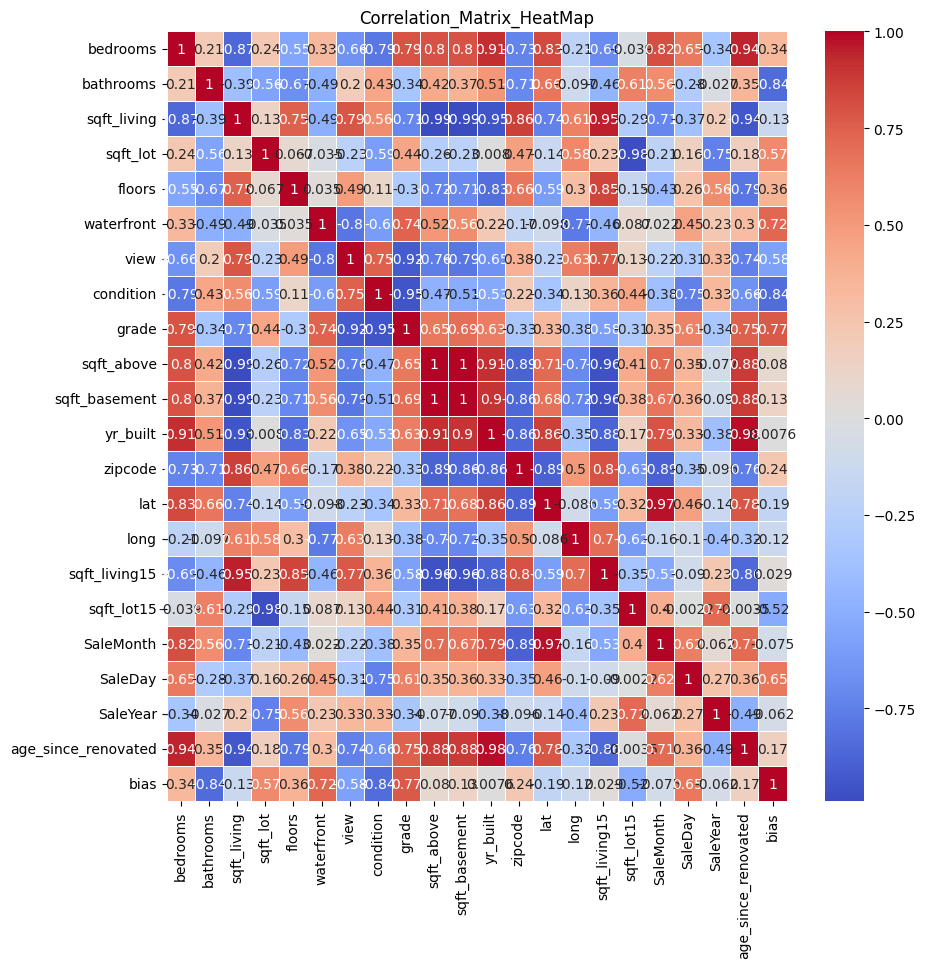

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = weight_distribution.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation_Matrix_HeatMap')
plt.show()

# Bonus. In-class competition (10 bonus pts)

We will host a in-class competition using the IA1 data, where you are encouraged to explore different ways to improve the prediction performance by manipunating the data. This could include: feature engineering such as removing, transforming features, constructing new features based on existing ones, using different encoding for the discrete features; data manipulation such as identifying and removing potential outliers; and target manipulation such as log transforming the price target. This is where you can get creative and test your ideas out.

To participate in this competition, use the following link:

https://www.kaggle.com/t/eae3afb743bd4140b6f5b6abbfe2a0e8


You should continue working in the same team for this competition. The training and validation data provided on the kaggle site are the same as the IA1 assignment. To participate, you will need to train your model and apply it to testing data provided on kaggle, and submit prediction files to be scored.

Your scoring will have two parts, the performance on the public leader board as well as the private leader board. The results on the public leader board is visible through out the competition so that you can gauge how well your model is performing in comparison to others. The private leader board shows the final evaluation performance and will be released only once after the competition is closed.

Each team will be allowed to submit 3 final entries to be evaluated. You can use the public leaderboard performance to pick which models to use for your final evaluation entries.

**Assginment of the bonus points:**

**Performance bonus:** the top 3 teams on the private leader board will recieve 10 bonus points.

**Participation bonus:** the 5 teams that submitted the most entries (with different performances) will recieve 5 bonus points. Also any team that participated the competition and got non-trivial performance will receive 2 bonus points.

Bonus points are capped at 10.


In [ ]:
epsilon   = 1e-4
lr        = 1e-4
max_grad  = 1e20
itterations=30000

mse_curve = {}                                           # Store MSE loss for different learning rate
weights   = {}                                           # Store weight learned for different learning rate

def remove_outliers(X, y, z_score_threshold):
    z_scores = np.abs((y - np.dot(X, w)) / np.std(y - np.dot(X, w)))
    outliers = z_scores > z_score_threshold
    return X[~outliers], y[~outliers]
#test dropping row
for i in columns_to_normalize:
  print("Test dropping:",i)
  X_new = processed_train_data[[col for col in processed_train_data.columns if col != i and col != 'price']+ ['bias']].values
  #X_new,Y_new=remove_outliers(X_new,Y_train,3.0)
  w, mse_tseq, norm = batch_gradient_descent(X_new,Y_train,lr,itterations,epsilon,max_grad)
  if norm>max_grad:
    continue
  mse_curve[str(i)] = mse_tseq                          # store sequence of T MSE in dictionary
  weights[str(i)]   = w                               # store trained weight in dictionary
  print("finalmse:",mse_tseq[-1])

Test dropping: bedrooms


100%|██████████| 30000/30000 [00:07<00:00, 3772.79it/s]


finalmse: 3.830583881092071
Test dropping: bathrooms


 43%|████▎     | 13025/30000 [00:03<00:04, 3982.82it/s]


KeyboardInterrupt: ignored

In [ ]:
for i in mse_curve:
  y = mse_curve[i]
  x = range(len(y))
  plt.plot(x, y, label=f'{i}')
  plt.title(f'MSE loss')
plt.legend(loc="upper right")
plt.show()

In [ ]:
#Test learning rate
epsilon   = 1e-2
max_grad  = 1e20
itterations=3000

mse_curve = {}                                           # Store MSE loss for different learning rate
weights   = {}                                           # Store weight learned for different learning rate
final_mses={}
#test dropping row
for lr in [x * y for x in [1,2,3,4,5,6,7,8,9] for y in[1e-1,1e-2,1e-3,1e-3,1e-4,1e-5]]:
  print("Test rate:",lr)
  X_new = processed_train_data[[col for col in processed_train_data.columns if col != 'floors' and col != 'price']+ ['bias']].values

  w, mse_tseq, norm = batch_gradient_descent(X_new,Y_train,lr,itterations,epsilon,max_grad)
  if norm>max_grad:
    continue
  mse_curve[str(i)] = mse_tseq                          # store sequence of T MSE in dictionary
  weights[str()]   = w                               # store trained weight in dictionary
  print("finalmse:",mse_tseq[-1])
  final_mses[lr]=mse_tseq[-1]
sorted_items = sorted(final_mses.items(), key=lambda x: x[1], reverse=True)

In [ ]:
print(sorted_items)

In [ ]:
epsilon   = 1e-4
lr        = 1e-3
max_grad  = 1e20
itterations=300000
print("Test dropping: condition and floors")

X_new = pd.concat([processed_train_data, processed_val_data],axis=0)[[col for col in processed_train_data.columns if col!='price' ]+ ['bias']].values
Y_new = pd.concat([processed_train_data, processed_val_data],axis=0)['price'].values
w, mse_tseq, norm = batch_gradient_descent(X_new,Y_new,lr,itterations,epsilon,max_grad)
print("finalmse:",mse_tseq[-1])

**Please provide the team name on the kaggle competition. Leave it blank if you opt not to participate.**

In [ ]:
def convert_zipcode_cityindex(zipcode):
  zipcity = {'98106': 6, '98023': 19, '98042': 5, '98119': 6, '98052': 30, '98115': 6, '98055': 15, '98058': 15, '98027': 4, '98029': 16, '98040': 20, '98034': 8, '98144': 6, '98028': 9, '98133': 6, '98198': 11, '98109': 6, '98008': 17, '98116': 6, '98117': 6, '98075': 18, '98136': 6, '98092': 10, '98056': 15, '98118': 6, '98105': 6, '98022': 21, '98125': 6, '98108': 3, '98038': 14, '98059': 15, '98033': 8, '98024': 24, '98168': 3, '98072': 32, '98002': 0, '98005': 17, '98199': 6, '98155': 26, '98122': 6, '98003': 19, '98004': 29, '98010': 2, '98031': 5, '98146': 13, '98103': 6, '98007': 17, '98166': 25, '98178': 3, '98074': 18, '98053': 30, '98112': 6, '98001': 7, '98177': 6, '98065': 27, '98102': 6, '98019': 23, '98107': 6, '98126': 6, '98014': 31, '98077': 32, '98006': 17, '98148': 25, '98032': 5, '98030': 5, '98188': 3, '98011': 22, '98045': 28, '98039': 1, '98070': 12}
  return zipcity[f'{zipcode}']

In [ ]:
# your code goes here
train_data = pd.read_csv(train_path)
val_data   = pd.read_csv(val_path)
kaggle_data=pd.read_csv(kaggle_path)
train_data.dtypes

id                 int64
date              object
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
price            float64
dtype: object

In [ ]:
zipcity = {'98106': 6, '98023': 19, '98042': 5, '98119': 6, '98052': 30, '98115': 6, '98055': 15, '98058': 15, '98027': 4, '98029': 16, '98040': 20, '98034': 8, '98144': 6, '98028': 9, '98133': 6, '98198': 11, '98109': 6, '98008': 17, '98116': 6, '98117': 6, '98075': 18, '98136': 6, '98092': 10, '98056': 15, '98118': 6, '98105': 6, '98022': 21, '98125': 6, '98108': 3, '98038': 14, '98059': 15, '98033': 8, '98024': 24, '98168': 3, '98072': 32, '98002': 0, '98005': 17, '98199': 6, '98155': 26, '98122': 6, '98003': 19, '98004': 29, '98010': 2, '98031': 5, '98146': 13, '98103': 6, '98007': 17, '98166': 25, '98178': 3, '98074': 18, '98053': 30, '98112': 6, '98001': 7, '98177': 6, '98065': 27, '98102': 6, '98019': 23, '98107': 6, '98126': 6, '98014': 31, '98077': 32, '98006': 17, '98148': 25, '98032': 5, '98030': 5, '98188': 3, '98011': 22, '98045': 28, '98039': 1, '98070': 12}
list(zipcity)

['98106',
 '98023',
 '98042',
 '98119',
 '98052',
 '98115',
 '98055',
 '98058',
 '98027',
 '98029',
 '98040',
 '98034',
 '98144',
 '98028',
 '98133',
 '98198',
 '98109',
 '98008',
 '98116',
 '98117',
 '98075',
 '98136',
 '98092',
 '98056',
 '98118',
 '98105',
 '98022',
 '98125',
 '98108',
 '98038',
 '98059',
 '98033',
 '98024',
 '98168',
 '98072',
 '98002',
 '98005',
 '98199',
 '98155',
 '98122',
 '98003',
 '98004',
 '98010',
 '98031',
 '98146',
 '98103',
 '98007',
 '98166',
 '98178',
 '98074',
 '98053',
 '98112',
 '98001',
 '98177',
 '98065',
 '98102',
 '98019',
 '98107',
 '98126',
 '98014',
 '98077',
 '98006',
 '98148',
 '98032',
 '98030',
 '98188',
 '98011',
 '98045',
 '98039',
 '98070']

In [ ]:
# Your code goes here
processed_train_data = train_data.drop(columns=['id'])
processed_val_data   = val_data.drop(columns=['id'])
processed_kaggle_data   = kaggle_data.drop(columns=['id'])

# from ia0
#2. handle the date feature and convert it to datetime
processed_train_data['date']=pd.to_datetime(processed_train_data['date'], format='%m/%d/%Y')

# extract month, day, and year into separate columns
processed_train_data['SaleMonth'] = processed_train_data['date'].dt.month
processed_train_data['SaleDay']   = processed_train_data['date'].dt.day
processed_train_data['SaleYear']  = processed_train_data['date'].dt.year

#drop the original date column
processed_train_data=processed_train_data.drop(columns=['date'])

#fix yr_renovated
processed_train_data['age_since_renovated'] = processed_train_data.apply(lambda row:
    row['SaleYear'] - row['yr_renovated'] if row['yr_renovated'] != 0 else row['SaleYear'] - row['yr_built'], axis=1)
processed_train_data = processed_train_data.drop(columns=['yr_renovated'])
columns_to_normalize = [col for col in processed_train_data.columns if col != 'price' and col != 'zipcode' and col != 'waterfront'and col != 'SaleMonth'and col != 'SaleDat'and col != 'SaleYear']
unnormalized_train_data=processed_train_data.copy()

# Calculate the mean and standard deviation for training data
mean_values          = processed_train_data[columns_to_normalize].mean()
std_deviation_values = processed_train_data[columns_to_normalize].std()

# Apply z-score normalization
processed_train_data[columns_to_normalize] = (processed_train_data[columns_to_normalize] - mean_values) / std_deviation_values
processed_train_data.dtypes

#2. handle the date feature and convert it to datetime
processed_val_data['date'] = pd.to_datetime(processed_val_data['date'], format='%m/%d/%Y')

#extract month, day, and year into separate columns
processed_val_data['SaleMonth'] = processed_val_data['date'].dt.month
processed_val_data['SaleDay']   = processed_val_data['date'].dt.day
processed_val_data['SaleYear']  = processed_val_data['date'].dt.year

#drop the original date column
processed_val_data=processed_val_data.drop(columns=['date'])
processed_val_data['age_since_renovated'] = processed_val_data.apply(lambda row:
    row['SaleYear'] - row['yr_renovated'] if row['yr_renovated'] != 0 else row['SaleYear'] - row['yr_built'], axis=1)
processed_val_data = processed_val_data.drop(columns=['yr_renovated'])
#normalize validation data using training distribution
unnormalized_val_data=processed_val_data.copy()

processed_val_data[columns_to_normalize] = (processed_val_data[columns_to_normalize] - mean_values) / std_deviation_values
processed_val_data.shape


#2. handle the date feature and convert it to datetime
processed_kaggle_data['date'] = pd.to_datetime(processed_kaggle_data['date'], format='%m/%d/%Y')

#extract month, day, and year into separate columns
processed_kaggle_data['SaleMonth'] = processed_kaggle_data['date'].dt.month
processed_kaggle_data['SaleDay']   = processed_kaggle_data['date'].dt.day
processed_kaggle_data['SaleYear']  = processed_kaggle_data['date'].dt.year

#drop the original date column
processed_kaggle_data=processed_kaggle_data.drop(columns=['date'])
processed_kaggle_data['age_since_renovated'] = processed_kaggle_data.apply(lambda row:
    row['SaleYear'] - row['yr_renovated'] if row['yr_renovated'] != 0 else row['SaleYear'] - row['yr_built'], axis=1)
processed_kaggle_data = processed_kaggle_data.drop(columns=['yr_renovated'])
#normalize validation data using training distribution
unnormalized_val_data=processed_kaggle_data.copy()

processed_kaggle_data[columns_to_normalize] = (processed_kaggle_data[columns_to_normalize] - mean_values) / std_deviation_values
processed_kaggle_data.shape


(5583, 21)

In [ ]:
for i in ['waterfront','zipcode','SaleDay','SaleMonth']:
  processed_train_data = pd.get_dummies(processed_train_data, columns=[i], prefix=[i])
  processed_val_data = pd.get_dummies(processed_val_data, columns=[i], prefix=[i])
  processed_kaggle_data = pd.get_dummies(processed_kaggle_data, columns=[i], prefix=[i])


processed_kaggle_data

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,...,SaleMonth_3,SaleMonth_4,SaleMonth_5,SaleMonth_6,SaleMonth_7,SaleMonth_8,SaleMonth_9,SaleMonth_10,SaleMonth_11,SaleMonth_12
0,-0.388520,0.169158,0.539525,-0.186218,0.917732,-0.304487,-0.634184,-0.563015,0.458980,0.253574,...,0,0,0,0,0,0,0,0,0,1
1,-0.388520,-0.157796,-0.435820,-0.166224,-0.922332,-0.304487,-0.634184,0.290361,-0.130378,-0.662576,...,0,0,0,0,0,0,0,0,0,0
2,-0.388520,0.496112,1.624459,-0.125282,-0.922332,-0.304487,-0.634184,0.290361,0.086121,3.231061,...,0,1,0,0,0,0,0,0,0,0
3,-1.426996,-1.465613,-1.005685,-0.215851,-0.922332,-0.304487,0.888924,-0.563015,-1.116649,0.024536,...,0,0,1,0,0,0,0,0,0,0
4,-0.388520,-0.157796,-0.205683,-0.024024,0.917732,-0.304487,-0.634184,-0.563015,0.122204,-0.662576,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5578,0.649956,1.803929,3.103915,-0.133680,-0.002300,-0.304487,-0.634184,2.850491,1.589583,3.460098,...,0,0,1,0,0,0,0,0,0,0
5579,0.649956,0.496112,1.140074,-0.171330,0.917732,2.354791,-0.634184,1.143738,1.599205,-0.662576,...,0,0,0,0,0,0,0,1,0,0
5580,0.649956,0.496112,0.484730,-0.215302,0.917732,-0.304487,-0.634184,1.143738,0.879949,-0.662576,...,0,0,0,0,0,0,0,1,0,0
5581,-0.388520,0.496112,-0.841301,-0.328131,0.917732,-0.304487,-0.634184,0.290361,-0.731762,-0.364827,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
processed_train_data['bias'] = 1
processed_val_data['bias']   = 1
processed_kaggle_data['bias']   = 1

# columns_to_normalize.remove('long')
# columns_to_normalize.remove('lat')
# columns_to_normalize += [f'city_{i}' for i in range(33)]

#columns_to_normalize += [f'zipcode_{i}' for i in num_city]
# feature matricesa
columns_to_normalize = [col for col in processed_train_data.columns if col != 'price' and col != 'zipcode' and col != 'waterfront'and col != 'SaleMonth'and col != 'SaleDat'and col != 'SaleYear']

X_train      = processed_train_data[columns_to_normalize + ['bias'] ].values
X_validation = processed_val_data[columns_to_normalize   + ['bias'] ].values
X_kaggle     = processed_kaggle_data[columns_to_normalize + ['bias'] ].values

#target vectors
Y_train      = processed_train_data['price'].values
Y_validation = processed_val_data['price'].values

print(X_train.shape)

(8000, 133)


In [ ]:
X_kaggle

array([[-0.38851993,  0.16915795,  0.53952482, ...,  0.        ,
         0.        ,  1.        ],
       [-0.38851993, -0.15779629, -0.43582017, ...,  0.        ,
         0.        ,  1.        ],
       [-0.38851993,  0.4961122 ,  1.62445914, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.64995632,  0.4961122 ,  0.48473016, ...,  0.        ,
         0.        ,  1.        ],
       [-0.38851993,  0.4961122 , -0.84130067, ...,  0.        ,
         0.        ,  1.        ],
       [-1.42699618, -1.79256753, -1.15910972, ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
from tqdm import tqdm

def batch_gradient_descent(X, Y, learning_rate, num_iterations, epsilon=None, max_grad=False):
    w = np.zeros(X.shape[1])
    N=X.shape[0]
    mse_tseq = []  # To store mse for graph plotting

    for epoch in tqdm(range(num_iterations)):
      # Calculate predictions
      y_pred = np.dot(X, w)

      # Calculate gradient
      gradient = (-2/N) * np.dot(X.T, Y - y_pred)
      # Update the weight vector
      w -= learning_rate * gradient

      # Calculate the mean squared error
      mse = np.mean((Y - y_pred) ** 2)
      mse_tseq.append(mse)
      norm=np.linalg.norm(gradient)
      if epsilon and norm < epsilon:
        print("Converged at epoch", epoch)
        break
      if max_grad and norm > max_grad:
        print("Diverged at epoch", epoch)
        break

    return w, mse_tseq,norm

100%|██████████| 200000/200000 [02:58<00:00, 1123.01it/s]


final mse: 2.3176340443509598
Trained Weight Vectors
[-1.95176340e-01  1.82893962e-01  8.41199824e-01  1.12694753e-01
 -2.47565172e-01  4.57341890e-01  1.95869678e-01  6.78319925e-01
  8.97919514e-01  4.82117596e-02 -3.41701321e-01  5.38862846e-01
 -2.39469697e-01  7.88884016e-02 -4.52480258e-02 -1.27960938e-01
 -7.93159364e-01  3.75143758e+00 -1.14594723e+00 -7.77815825e-01
 -1.40599060e+00  5.12530341e+00  9.42950341e-01  7.85695431e-01
  2.65423368e-01  2.19205035e-01 -1.50739327e-01 -1.40660953e+00
 -1.04517143e+00 -1.32590064e+00 -5.40183875e-01 -1.58728878e+00
  1.23664502e-01  2.28828002e-01 -1.56753526e+00  4.41656527e-01
 -1.24116111e+00 -1.15761189e+00 -1.23797011e+00  1.04012619e+00
 -6.59006493e-01 -5.77003182e-01  1.24334382e+01  2.82155113e+00
 -1.12474954e+00  8.79630320e-02 -1.38468639e-02 -2.63693506e-01
 -1.12751066e+00 -8.77594268e-01 -1.17317735e+00 -8.82577176e-01
 -5.67885231e-01 -1.93214103e+00 -1.07427968e+00 -3.15229081e-01
 -1.33320174e-01 -1.18294772e+00 -1.3

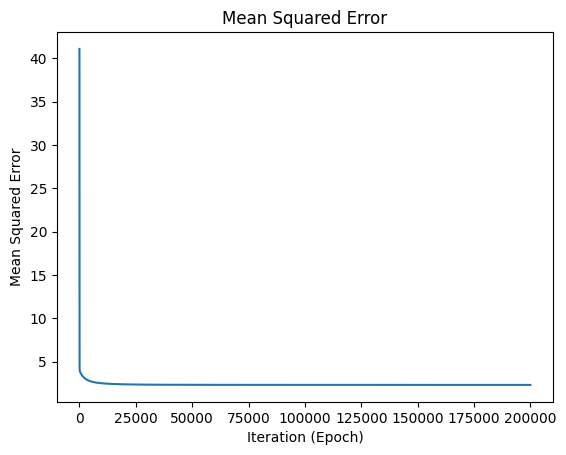

In [ ]:
# Your code goes here
from tqdm import tqdm

num_iterations = 200000                                 # count iteration
learning_rate  = 1e-2                          # initialize learning rate
mse_tseq  = []                                         # store mse for graph plotting
epsilon   = 1e-4                                     # Stopping criteria
max_grad  = 1e20                                         # Stopping criteria for divergence

w, mse_tseq,_=batch_gradient_descent(X_train,Y_train,learning_rate,num_iterations,epsilon,max_grad)
print("final mse:",mse_tseq[-1])
# output trained weight
print("Trained Weight Vectors")
print(np.squeeze(w))

# output sequence of T MSE losses
plt.plot(mse_tseq)
plt.title("Mean Squared Error")
plt.xlabel("Iteration (Epoch)")
plt.ylabel("Mean Squared Error")
plt.show()

In [103]:
import csv

#X_kaggle = processed_kaggle_data[[col for col in processed_kaggle_data.columns if col != 'floors' and col != 'price']+ ['bias']].values
#Y_kaggle=processed_train_data['price'].values
#Y_pred = np.dot(X, weights['floors'])
#Y_pred = [np.dot(row, weights['floors']) for row in X]
Y_pred = np.dot(X_kaggle, w)
print(Y_pred.shape)
print(Y_pred)


#mse = np.mean((Y_train - Y_pred) ** 2)
# print(mse)
with open('/content/gdrive/MyDrive/AI534/out.csv', 'w', newline='') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write the header row (if needed)
    csv_writer.writerow(['id', 'price'])  # Optional: Write column headers
    # Iterate through the data and write rows
    for id_value, data_value in zip(kaggle_data['id'], Y_pred):
        csv_writer.writerow([id_value, data_value])

print(f"CSV file /content/gdrive/MyDrive/AI534/out.csv has been created.")



(5583,)
[5.86093934 4.51567266 8.23852915 ... 5.44453397 4.79024013 3.0917691 ]
CSV file /content/gdrive/MyDrive/AI534/out.csv has been created.


In [102]:
X_kaggle

array([[-0.38851993,  0.16915795,  0.53952482, ...,  1.        ,
         1.        ,  1.        ],
       [-0.38851993, -0.15779629, -0.43582017, ...,  0.        ,
         1.        ,  1.        ],
       [-0.38851993,  0.4961122 ,  1.62445914, ...,  0.        ,
         1.        ,  1.        ],
       ...,
       [ 0.64995632,  0.4961122 ,  0.48473016, ...,  0.        ,
         1.        ,  1.        ],
       [-0.38851993,  0.4961122 , -0.84130067, ...,  0.        ,
         1.        ,  1.        ],
       [-1.42699618, -1.79256753, -1.15910972, ...,  0.        ,
         1.        ,  1.        ]])